In [45]:
# Import necessary libraries
import pandas as pd
import numpy as np
import db_utils, sqlalchemy
import matplotlib.pyplot as plt
from matplotlib_venn import venn2, venn2_circles
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
import seaborn as sns
from scipy.stats import fisher_exact
from scipy import stats
import math
import os
import gzip
import re
import glob
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
import math
plt.rcParams['axes.spines.top'] = False # remove top spine
plt.rcParams['axes.spines.right'] = False # remove right spine
plt.rcParams['pdf.fonttype'] = 42 # Set the fonttype to export fonts as font files
plt.rcParams['font.family'] = 'Arial'
sns.set_palette("colorblind")
global_fontsize = 12
figsize = (3,3)
legend_fontsize = 8
bbox_to_anchor =(1.0, 1.0)

In [ ]:
# Define a function to create a custom autopct for matplotlib pie chart returning a formatted string
# with the percentage and value
def make_autopct(data):
    def my_autopct(pct):
        total = sum(data)
        val = int(round(pct*total/100.0))
        if val/total < 0.1:
            return ' '
        else:
            return '{p:.2f}%\n({v:d})'.format(p=pct,v=val)
    return my_autopct

In [2]:
# Read in manual curation dataset as a DataFrame and group it based on 'DDI_type', so each row corresponds to a
# single DDI type (take the max value out of all rows corresponding to the same DDI type for all columns (curation
# features))
df= pd.read_csv('/Users/johgeist/Downloads/DDI_curation table_wihtout_homo_protein_structures_4.csv')
df = df[~df['DDI_type'].str.contains('curation')]

In [7]:
grouped = df.groupby('DDI_type').agg({'Has_abstract': max, 'Abstract_approved': max,
                           'Publication_approved': max, 'ProtCID_cluster': max,
                           'ProtCID_cluster_with_PDB_ID': max, 'ProtCID_cluster_approved': max,
                          'DDI_approved': max, 'non-approved category': 'first'})

In [8]:
grouped

,Has_abstract,Abstract_approved,Publication_approved,ProtCID_cluster,ProtCID_cluster_with_PDB_ID,ProtCID_cluster_approved,DDI_approved,non-approved category
DDI_type,,,,,,,,
PF00004_PF10584,1.0,0.0,0.0,1.0,1.0,1.0,0.0,HMM (at least one Pfam has unfolded structure)
PF00009_PF01873,1.0,0.0,1.0,1.0,1.0,0.0,1.0,None
PF00010_PF02344,1.0,0.0,0.0,1.0,1.0,0.0,0.0,crystal contact
PF00019_PF00041,1.0,0.0,0.0,0.0,NaN,NaN,0.0,crystal contact
PF00023_PF07686,1.0,0.0,0.0,0.0,NaN,NaN,0.0,synthetic construct
...,...,...,...,...,...,...,...,...
PF16004_PF00400,1.0,0.0,0.0,1.0,1.0,1.0,0.0,HMM (at least one Pfam has unfolded structure)
PF17292_PF08644,1.0,0.0,0.0,1.0,1.0,1.0,0.0,contact is minimal
PF17820_PF16523,1.0,0.0,0.0,0.0,NaN,NaN,0.0,HMM (at least one Pfam has unfolded structure)


In [9]:
# check how many different non-approved categories there are
grouped['non-approved category'].unique()

array(['HMM (at least one Pfam has unfolded structure)', None,
       'crystal contact', 'synthetic construct', 'contact is minimal',
       'HMM (domain annotation)'], dtype=object)

In [10]:
# create a summary df holding the total counts of DDI types in each non-approved category
value_counts = df['non-approved category'].value_counts()
summary_df = value_counts.reset_index()
summary_df.columns = ['Category', 'Count']

In [11]:
summary_df['Category'] = summary_df['Category'].str.capitalize()
summary_df.at[0, 'Category'] = 'Minimal contact'
summary_df.at[3, 'Category'] = 'Non-folded HMM'
summary_df.at[4, 'Category'] = 'Domain annotation'

In [12]:
summary_df

,Category,Count
0,Minimal contact,12
1,Crystal contact,9
2,Synthetic construct,5
3,Non-folded HMM,5
4,Domain annotation,1


<Figure size 7680x5760 with 0 Axes>

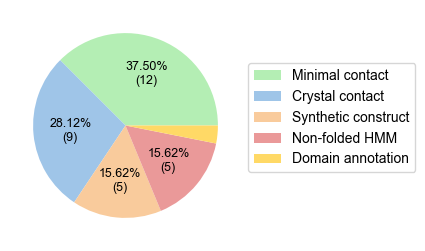

In [77]:
# make a pie chart to visualize the proportions of the different non-approved categories
my_pal = ['#b4eeb4', '#9fc5e8', '#f9cb9c', '#ea9999', '#ffd966']



labels = summary_df['Category'].tolist()
data = summary_df['Count'].tolist()
my_autopct= make_autopct(data)
plt.figure(dpi=1200) 
fig, ax = plt.subplots(figsize=(3,3))
ax.pie(data, colors = my_pal,autopct= my_autopct, textprops={'fontsize': 9})
ax.legend(labels= labels, bbox_to_anchor=(1, 0.8))
# domain annotation yellow -> 1 case, 3.12%

#plt.savefig('/Users/johgeist/Downloads/categories_of_non_approval_DDI_types.jpg', transparent=True, bbox_inches='tight', dpi=1200)
plt.show()

In [47]:
df_gr = df.groupby('DDI_type').agg({'DDI_approved': max})
app = df_gr[df_gr['DDI_approved']==1]
n_app = df_gr[df_gr['DDI_approved']==0]

<Figure size 7680x5760 with 0 Axes>

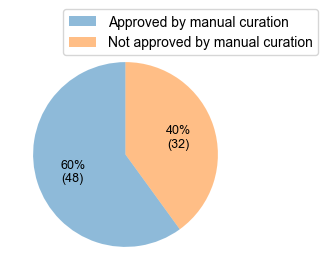

In [75]:
# Create another pie chart visualizing the proportions of approved vs. non-approved DDI types in 
# the manual curation dataset

my_pal = ['tab:blue', 'tab:orange']

labels = ['Approved by manual curation', 'Not approved by manual curation']
data = [len(app), len(n_app)]
my_autopct= make_autopct(data)
plt.figure(dpi=1200) 
fig, ax = plt.subplots(figsize=(3,3))
ax.pie(data, colors = my_pal,autopct= my_autopct, textprops={'fontsize': 9},startangle= 90, wedgeprops=dict(alpha=0.5))
ax.legend(labels= labels, bbox_to_anchor=(0.2, 0.9))

#plt.savefig('/Users/johgeist/Downloads/approved_non_approved_DDI_types.jpg', transparent=True, bbox_inches='tight', dpi=1200)
plt.show()